# Virtual ADC example
---


## Load the bitstream into the Programmable Logic

In [11]:
# Import the X-HEEP Python class
from pynq import x_heep
# Allow the import of all modules in this directory
import sys
import os

SDK_PATH = "/home/xilinx/x-heep-femu-sdk/"

sys.path.append(SDK_PATH + "sw/arm/apps/adc-emu/src")

from timeseries import *

# Load the X-HEEP bitstream
xh = x_heep()

## Generate an input array to use as signal 

In [12]:
import numpy as np

APP_DIR = SDK_PATH + 'sw/riscv/apps/adc-emu/'
ADC_BIN_NAME = 'adc_in.bin'

MAX_POSSIBLE_DATA_LENGTH = 2048
INPUT_DATA_LENGTH = 800


# Generate a binary file from a txt
if 0:
    with open( APP_DIR + 'EpiPhone.txt', 'r') as f: 
        din = f.readlines()

    # Keep only the first few values
    din_f = din[:INPUT_DATA_LENGTH]
    din_f = np.array(din_f, dtype=float)

    # Don't normalize, just round to u16
    din_u16 = din_f.astype(np.uint16)

    # Write the definitions header file to share information with the C code
    with open( APP_DIR + 'definitions.h', 'w+') as f: 
        f.write(f"#define INPUT_DATA_LENGTH {INPUT_DATA_LENGTH} \n")

    # Save the array to a binary file
    din_norm_u32 = din_u16.astype(np.uint32).copy()
    with open(APP_DIR + ADC_BIN_NAME,'wb') as file:
        din_norm_u32.byteswap(True).tofile(file)


# Take a pre-generated binary file
if 1: 
    import shutil
    import os
    from timeseries import Timeseries

    src         = SDK_PATH + 'sw/arm/apps/adc-emu/out/'
    src_name    = 'Raw_Norm'
    ext_bin     = '.bin'
    ext_pkl     = '.pkl'
    dst         = APP_DIR
    dst_name    = ADC_BIN_NAME

    # Remove the existing file at the destination path
    if os.path.exists(dst+dst_name):
        os.remove(dst+dst_name)
    shutil.copy( src+src_name+ext_bin, dst+dst_name )


    raw_norm = Timeseries.load(src+src_name+ext_pkl)
    print(raw_norm.data[:10])




[-54.71059056213109, -65.92874728308456, -61.53306138426197, -52.584700804516, -66.79872678389319, -54.9133677390113, -66.38009003162438, -62.2068049074446, -53.23227953068183, -68.00230744666604]


## Compile the code and run the application
You can change the variable `SKIP_COMPILE`  to 1 to avoid compiling each time.

You can change the variable `SKIP_MEMORY`   to 1 to avoid generating the ADC memory each time.

You can change the variable `VERBOSE`       to 0 to supress the live printing of the UART.

In [13]:
# Skip compiling if all you want to do is run the application
# Note that the compilation is affected by the parameters written to the definitions.h file
SKIP_COMPILE = 0

# Skip the memory generation
SKIP_MEMORY = 0

# Wether to see the X-HEEP UART output live.
VERBOSE = 1

# Compile the application
if SKIP_COMPILE or xh.compile_app("adc-emu"):

    if not SKIP_MEMORY:
        # Write the ADC data to the virtual ADC
        adc = xh.init_adc_mem() # Init the ADC memory
        xh.reset_adc_mem(adc)   # Reset the ADC memory
        xh.write_adc_mem(adc)   # Write the ADC memory

    t, sf = xh.thread_start(VERBOSE)   # Start a background thread that reads from the UART
    out, _ = xh.run_app()       # Run the application (disregarding the error output)
    xh.thread_stop(t, sf)       # Stop the background thread that reads from the UART

✅ Compile SUCCESS
-54
-65
-61
-52
-66
-54
-66
-62
-53
-68
-56
-68
-65
-56
-72
-59
-71
-66
-56
-72
-59
-71
-66
-56
-72
-59
-71
-66
-55
-72
-59
-70
-66
-55
-72
-59
-70
-66
-54
-71
-57
-68
-64
-52
-69
-55
-66
-63
-51
-71
-51
-63
-60
-47
-69
-53
-65
-62
-45
-68
-52
-64
-61
-43
-69
-50
-62
-59
-40
-67
-47
-59
-57
-36
-65
-45
-56
-55
-33
-63
-42
-53
-53
-31
-61
-40
-51
-51
-28
-60
-39
-50
-49
-25
-58
-36
-48
-49
-26
-58
-35
-43
-41
-17
-51
-31
-41
-43
-18
-52
-29
-38
-41
-14
-50
-27
-36
-39
-11
-48
-25
-34
-38
-9
-45
-22
-30
-36
-6
-44
-20
-26
-32
-1
-41
-15
-25
-31
-3
-41
-15
-22
-25
03
-34
-11
-19
-24
06
-33
-8
-16
-22
08
-32
-8
-15
-22
08
-32
-8
-13
-21
10
-31
-6
-12
-20
11
-30
-6
-11
-20
12
-30
-5
-9
-19
14
-29
-4
-9
-19
14
-29
-4
-7
-18
17
-25
00
-4
-14
18
-25
00
-3
-14
19
-23
01
-2
-12
20
-23
01
-2
-12
20
-23
01
-2
-11
20
-22
03
-1
-9
21
-21
04
00
-7
23
-19
06
01
-6
23
-18
07
01
-5
23
-17
09
03
-3
24
-17
09
02
-3
23
-17
09
02
-2
23
-18
09
01
-3
20
-19
10
02
02
29
-9
23
17
13
45
06
39
3

### Check if the CPU's output is the same as the expected result


In [9]:
app_out = [int(x) for x in xh.uart_data if x.strip()]
print(app_out)

[-54, -65, -61, -52, -66, -54, -66, -62, -53, -68, -56, -68, -65, -56, -72, -59, -71, -66, -56, -72, -59, -71, -66, -56, -72, -59, -71, -66, -55, -72, -59, -70, -66, -55, -72, -59, -70, -66, -54, -71, -57, -68, -64, -52, -69, -55, -66, -63, -51, -71, -51, -63, -60, -47, -69, -53, -65, -62, -45, -68, -52, -64, -61, -43, -69, -50, -62, -59, -40, -67, -47, -59, -57, -36, -65, -45, -56, -55, -33, -63, -42, -53, -53, -31, -61, -40, -51, -51, -28, -60, -39, -50, -49, -25, -58, -36, -48, -49, -26, -58, -35, -43, -41, -17, -51, -31, -41, -43, -18, -52, -29, -38, -41, -14, -50, -27, -36, -39, -11, -48, -25, -34, -38, -9, -45, -22, -30, -36, -6, -44, -20, -26, -32, -1, -41, -15, -25, -31, -3, -41, -15, -22, -25, 3, -34, -11, -19, -24, 6, -33, -8, -16, -22, 8, -32, -8, -15, -22, 8, -32, -8, -13, -21, 10, -31, -6, -12, -20, 11, -30, -6, -11, -20, 12, -30, -5, -9, -19, 14, -29, -4, -9, -19, 14, -29, -4, -7, -18, 17, -25, 0, -4, -14, 18, -25, 0, -3, -14, 19, -23, 1, -2, -12, 20, -23, 1, -2, -12, 20,

In [10]:
if 0:
    app_out = [int(x) for x in xh.uart_data if x.strip()]

    exp_out = list(din_u16)

    print(app_out)
    print(exp_out)


    if all([a == e for a,e in zip(app_out, exp_out)]) and len(app_out) == len(exp_out): print("✅ SUCCESS")
    else: print("❌ FAILED")


NameError: name 'din_u16' is not defined

## Plot the input and output

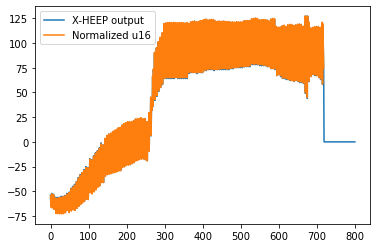

In [ ]:
import matplotlib.pyplot as plt

plt.plot(app_out)
plt.plot(raw_norm.data)

plt.legend(["X-HEEP output", raw_norm.name])

